## First Attempt

This is slightly wrong but I still don't know why the objective function can be negative

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

In [1]:
stations = ['station 1', 'station 2', 'station 3', 'station 4', 'station 5']
start_levels = {'station 1': 21, 'station 2': 3, 'station 3': 0, 'station 4': 48, 'station 5': 9}
optimal_levels = {'station 1': 15, 'station 2': 12, 'station 3': 18, 'station 4': 12, 'station 5': 24}
over_stations, under_stations = [], []

# fill over, under stations
for station in stations:
    if start_levels[station] >= optimal_levels[station]:
        over_stations.append(station)
    elif start_levels[station] <= optimal_levels[station]:
        under_stations.append(station)
        
T = 10 # number of time steps
K = 2 # number of trucks
L = 3 # number of bikes that can be moved in one time step

In [5]:
model = gp.Model("bike_rebalancing")
# N = G.nodes()
# What is this for??

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-20


In [6]:
'''
decision variables: 
x: whether or not truck k is at station s at time t
y: number of bikes available to truck k is at station s at time t
b: number of bikes in truck k at time t
'''
x, y, b = {}, {}, {}

for t in range(1, T+1):
    for k in range(1, K+1):
        for s in stations:
            x[s,t,k] = model.addVar(name="x_%s,%s,%s"%(s,t,k), vtype=GRB.BINARY)
            y[s,t,k] = model.addVar(name="y_%s,%s,%s"%(s,t,k), vtype=GRB.INTEGER)
        b[t,k] = model.addVar(name="b_%s,%s"%(t,k), vtype=GRB.INTEGER)

model.update()

In [7]:
# objective function

objective = gp.quicksum((optimal_levels[s] - y[s, T, 1]) for s in under_stations) \
            + gp.quicksum((y[s,T,1] - optimal_levels[s]) for s in over_stations)
model.setObjective(objective, sense=GRB.MINIMIZE)

In [8]:
# constraints

# each truck must be at exactly 1 station always
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(x[s,t,k] for s in stations) == 1)

# initiate
for s in stations:
    model.addConstr(sum(y[s,1,k] for k in range(1, K+1)) == start_levels[s])

# rebalancing can only bring a station closer to optimal level
for t in range(1, T+1):
    for s in over_stations:
        model.addConstr(optimal_levels[s] <= sum(y[s,t,k] for k in range(1, K+1)))
        model.addConstr(sum(y[s,t,k] for k in range(1, K+1)) <= start_levels[s])
    for s in under_stations:
        model.addConstr(start_levels[s] <= sum(y[s,t,k] for k in range(1, K+1)))
        model.addConstr(sum(y[s,t,k] for k in range(1, K+1)) <= optimal_levels[s])

# total number of bikes is constant
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(y[s,t,k] for s in stations) + b[t,k] == sum(y[s,1,k] for s in stations) + b[1,k])

# can move only when truck is at station, number of bikes moved is bounded by 
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(y[s,t,k] - y[s,t-1,k] <= L * x[s,t,k])
            model.addConstr(y[s,t-1,k] - y[s,t,k] <= L * x[s,t,k])

# add last constraint later...

In [9]:
model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 325 rows, 220 columns and 1066 nonzeros
Model fingerprint: 0x8427abed
Variable types: 0 continuous, 220 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 72.0000000
Presolve removed 55 rows and 38 columns
Presolve time: 0.01s
Presolved: 270 rows, 182 columns, 770 nonzeros
Variable types: 0 continuous, 182 integer (88 binary)

Root relaxation: objective -1.200000e+01, 219 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     -12.0000000  -12.00000  0.0

## Slight Fix

As you can see, I was getting negative values for the objective function, which is wrong. Introducing deviations seems to fix it...

In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

stations = ['station 1', 'station 2', 'station 3', 'station 4', 'station 5']
start_levels = {'station 1': 30, 'station 2': 15, 'station 3': 15, 'station 4':0, 'station 5': 15}
optimal_levels = {'station 1': 15, 'station 2': 15, 'station 3': 15, 'station 4': 15, 'station 5': 15}
over_stations, under_stations = [], []

# Fill over and under stations
for station in stations:
    if start_levels[station] > optimal_levels[station]:
        over_stations.append(station)
    elif start_levels[station] < optimal_levels[station]:
        under_stations.append(station)
        
T = 10 # Number of time steps
K = 1 # Number of trucks
L = 3 # Number of bikes that can be moved in one time step

travel_time = {
    ('station 1', 'station 2'): 1,
    ('station 1', 'station 3'): 1,
    ('station 1', 'station 4'): 3,
    ('station 1', 'station 5'): 1,
    ('station 2', 'station 3'): 1,
    ('station 2', 'station 4'): 3,
    ('station 2', 'station 5'): 1,
    ('station 3', 'station 4'): 3,
    ('station 3', 'station 5'): 1,
    ('station 4', 'station 5'): 3,
    # Symmetric entries
    ('station 2', 'station 1'): 1,
    ('station 3', 'station 1'): 1,
    ('station 4', 'station 1'): 3,
    ('station 5', 'station 1'): 1,
    ('station 3', 'station 2'): 1,
    ('station 4', 'station 2'): 3,
    ('station 5', 'station 2'): 1,
    ('station 4', 'station 3'): 3,
    ('station 5', 'station 3'): 1,
    ('station 5', 'station 4'): 3,
    # Diagonal entries
    ('station 1', 'station 1'): 1,
    ('station 2', 'station 2'): 1,
    ('station 3', 'station 3'): 1,
    ('station 4', 'station 4'): 1,
    ('station 5', 'station 5'): 1
}

model = gp.Model("bike_rebalancing")

# Decision variables
x, y, b ,z= {}, {}, {}, {}
for t in range(1, T+1):
    for k in range(1, K+1):
        for s in stations:
            x[s, t, k] = model.addVar(name="x_%s,%s,%s" % (s, t, k), vtype=GRB.BINARY)
            y[s, t, k] = model.addVar(name="y_%s,%s,%s" % (s, t, k), vtype=GRB.INTEGER)
        b[t, k] = model.addVar(name="b_%s,%s" % (t, k), vtype=GRB.INTEGER)
        for s1 in stations:
            for s2 in stations:
                #if s1 != s2:
                z[s1, s2, t, k] = model.addVar(name="z_%s,%s,%s,%s" % (s1, s2, t, k), vtype=GRB.BINARY)

# Auxiliary variables for absolute deviation
deviation = {}
for s in stations:
    deviation[s] = model.addVar(name="deviation_%s" % s, vtype=GRB.INTEGER)

model.update()

# Objective function: minimize total absolute deviation from optimal levels
objective = gp.quicksum(deviation[s] for s in stations)
model.setObjective(objective, sense=GRB.MINIMIZE)

# Constraints

# Each truck must be at exactly 1 station always
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(x[s, t, k] for s in stations) == 1)

# Initialize bike levels at time 1
for s in stations:
    model.addConstr(sum(y[s, 1, k] for k in range(1, K+1)) == start_levels[s])

# Rebalancing can only bring a station closer to optimal level
for t in range(1, T+1):
    for s in over_stations:
        model.addConstr(optimal_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= start_levels[s])
    for s in under_stations:
        model.addConstr(start_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= optimal_levels[s])

# Total number of bikes is constant
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(y[s, t, k] for s in stations) + b[t, k] == sum(y[s, 1, k] for s in stations) + b[1, k])

# Can move only when truck is at station; number of bikes moved is bounded
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(y[s, t, k] - y[s, t-1, k] <= L * x[s, t, k])
            model.addConstr(y[s, t-1, k] - y[s, t, k] <= L * x[s, t, k])

# Constraint 8 in paper
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in over_stations:
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) <= L + (y[s,t,k] - y[s,t-1,k]))
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) >= -L - (y[s,t,k] - y[s,t-1,k]))
        for s in under_stations:
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) <= L - (y[s,t,k] - y[s,t-1,k]))
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) >= -L + (y[s,t,k] - y[s,t-1,k]))

# TEST: each truck can only house L bikes
for k in range(1, K+1):
    for t in range(1,T+1):
        model.addConstr(b[t,k] <= L)

# Absolute deviation constraints
for s in stations:
    model.addConstr(deviation[s] >= optimal_levels[s] - sum(y[s, T, k] for k in range(1, K+1)))
    model.addConstr(deviation[s] >= sum(y[s, T, k] for k in range(1, K+1)) - optimal_levels[s])

for t in range(1, T):
    for k in range(1, K+1):
        for s1 in stations:
            for s2 in stations:
            #if s1 != s2:
                if t + travel_time[(s1, s2)] <= T:
                    model.addConstr(z[s1, s2, t, k] <= x[s1, t, k])
                    model.addConstr(z[s1, s2, t, k] <= x[s2, t + 1, k])
                    model.addConstr(z[s1, s2, t, k] >= x[s1, t, k] + x[s2, t + 1, k] - 1)

# want to say that after traveling to station 4, it must remain there for the next 2 time steps
for t in range(1, T):
    for k in range(1, K+1):
        for s1 in stations:
            for s2 in stations:
                if t + travel_time[(s1, s2)] <= T:
                    for t1 in range(t+1, t + travel_time[(s1,s2)]):
                        # if z == 1, then x[s1] + x[s2] == 2
                        # if z == 0, then x[s1] + x[s2] can be 1 or 0
                        model.addConstr(x[s1,t,k] + x[s2,t1,k] >= 2 * z[s1,s2,t,k]) 
                        model.addConstr(x[s1,t,k] + x[s2,t1,k] <= 1 + z[s1,s2,t,k]) 
                        
# at beginning and end, there must be no bikes in trucks
model.addConstr(gp.quicksum(b[T,k] for k in range(1, K+1)) == 0)
model.addConstr(gp.quicksum(b[1,k] for k in range(1, K+1)) == 0)


model.optimize()

Restricted license - for non-production use only - expires 2025-11-24
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 17.7.0 17G14042)

CPU model: Intel(R) Core(TM) i5-4250U CPU @ 1.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1064 rows, 365 columns and 2784 nonzeros
Model fingerprint: 0xaa496013
Variable types: 0 continuous, 365 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Presolve removed 941 rows and 275 columns
Presolve time: 0.04s
Presolved: 123 rows, 90 columns, 387 nonzeros
Variable types: 0 continuous, 90 integer (43 binary)
Found heuristic solution: objective 30.0000000

Root relaxation: objective 2.460000e+01, 89 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

## Graphing

Something is still not working right because it seems like trucks are reducing the number of bikes in station 4 just by making trips back to station 4 again and again which doesn't make sense... intuitively, they would have to go to a different station first to drop off the bikes...

Truck 1 path: [(1, 'station 1', '0 bikes'), (2, 'station 1', '3 bikes'), (3, 'station 5', '3 bikes'), (6, 'station 4', '3 bikes'), (7, 'station 4', '1 bikes'), (8, 'station 4', '3 bikes'), (9, 'station 4', '0 bikes'), (12, 'station 1', '0 bikes'), (13, 'station 1', '0 bikes'), (14, 'station 1', '0 bikes'), (15, 'station 1', '3 bikes'), (18, 'station 4', '3 bikes'), (19, 'station 4', '0 bikes'), (20, 'station 4', '0 bikes')]


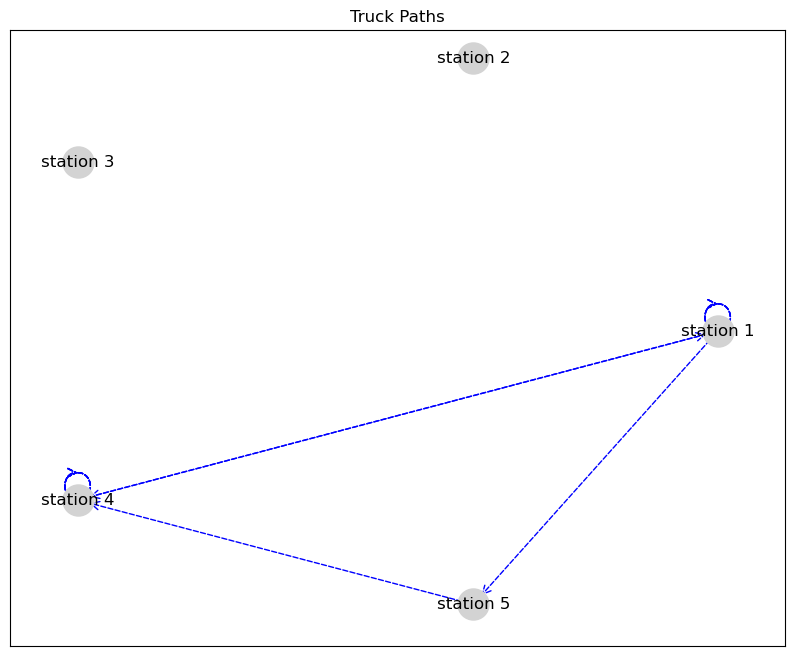

In [78]:
import matplotlib.pyplot as plt
import networkx as nx

truck_paths = {}
if model.status == GRB.OPTIMAL:
    for k in range(1, K+1):
        path = []
        for t in range(1, T+1):
            for s in stations:
                if x[s, t, k].x > 0.5:  # If the truck k is at station s at time t
                    path.append((t, s, '{} bikes'.format(int(b[t,k].x))))
                    break
        truck_paths[k] = path
        print(f"Truck {k} path: {path}")
else:
    print("No optimal solution found.")


# Visualize the truck paths
def plot_paths(truck_paths):
    G = nx.DiGraph()
    
    num_stations = len(stations)
    angle_step = 2 * np.pi / num_stations
    radius = 0.1  # You can adjust the radius as needed

    pos = {stations[i]: (np.cos(i * angle_step) * radius, np.sin(i * angle_step) * radius) for i in range(num_stations)}

    # Add nodes
    for station in stations:
        G.add_node(station)
    
    # Add edges with arrows for each truck path
    for k, path in truck_paths.items():
        for i in range(len(path) - 1):
            t1, s1 = path[i][:2]
            t2, s2 = path[i + 1][:2]
            G.add_edge(s1, s2, truck=k, time_step=t1)
    
    edge_colors = ['blue', 'red', 'green', 'purple']  # Different colors for different trucks
    # edge_styles = ['solid', 'dashed']  # Different styles for different trucks
    
    plt.figure(figsize=(10, 8))
    for k, path in truck_paths.items():
        edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=15, 
                               edge_color=edge_colors[k - 1], style='dashed', label=f'Truck {k}')
    
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    
    #plt.legend()
    plt.title("Truck Paths")
    plt.show()

# Plot the paths
plot_paths(truck_paths)


In [71]:
# print the transit times

for t in range(1, T):
    for k in range(1, K+1):
        for s1 in stations:
            for s2 in stations:
                if transit[s1,s2,t,k].x == 1:
                    print('Truck {} in transit from {} to {} at time {}'.format(k, s1, s2, t))

Truck 1 in transit from station 5 to station 5 at time 4
Truck 1 in transit from station 5 to station 5 at time 5
Truck 1 in transit from station 5 to station 5 at time 10
Truck 1 in transit from station 5 to station 5 at time 11
Truck 1 in transit from station 5 to station 5 at time 16
Truck 1 in transit from station 5 to station 5 at time 17


In [79]:
# print all the trips

for t in range(1, T):
    for k in range(1, K+1):
        for s1 in stations:
            for s2 in stations:
                if z[s1,s2,t,k].x == 1:
                    print('Trip from {} to {} starting at time {} by truck {}'.format(s1,s2,t,k))
                    # print('z[{}, {}, {}, {}] = {}'.format(s1,s2,t,k,z[s1,s2,t,k].x))

Trip from station 1 to station 1 starting at time 1 by truck 1
Trip from station 1 to station 1 starting at time 2 by truck 1
Trip from station 5 to station 5 starting at time 3 by truck 1
Trip from station 4 to station 4 starting at time 6 by truck 1
Trip from station 4 to station 4 starting at time 7 by truck 1
Trip from station 4 to station 4 starting at time 8 by truck 1
Trip from station 4 to station 4 starting at time 9 by truck 1
Trip from station 1 to station 1 starting at time 12 by truck 1
Trip from station 1 to station 1 starting at time 13 by truck 1
Trip from station 1 to station 1 starting at time 14 by truck 1
Trip from station 1 to station 1 starting at time 15 by truck 1
Trip from station 4 to station 5 starting at time 18 by truck 1
Trip from station 4 to station 5 starting at time 19 by truck 1


In [73]:
print('Time 0:', start_levels)
for t in range(1, T+1):
    dict = {}
    for s in stations:
        dict[s] = int(sum(y[s,t,k].x for k in range(1,K+1)))
    print('Time {}:'.format(t), dict)

Time 0: {'station 1': 30, 'station 2': 15, 'station 3': 15, 'station 4': 0, 'station 5': 15}
Time 1: {'station 1': 30, 'station 2': 15, 'station 3': 15, 'station 4': 0, 'station 5': 15}
Time 2: {'station 1': 27, 'station 2': 15, 'station 3': 15, 'station 4': 0, 'station 5': 15}
Time 3: {'station 1': 27, 'station 2': 15, 'station 3': 15, 'station 4': 0, 'station 5': 15}
Time 4: {'station 1': 27, 'station 2': 15, 'station 3': 15, 'station 4': 0, 'station 5': 15}
Time 5: {'station 1': 27, 'station 2': 15, 'station 3': 15, 'station 4': 0, 'station 5': 15}
Time 6: {'station 1': 27, 'station 2': 15, 'station 3': 15, 'station 4': 0, 'station 5': 15}
Time 7: {'station 1': 27, 'station 2': 15, 'station 3': 15, 'station 4': 2, 'station 5': 15}
Time 8: {'station 1': 27, 'station 2': 15, 'station 3': 15, 'station 4': 0, 'station 5': 15}
Time 9: {'station 1': 27, 'station 2': 15, 'station 3': 15, 'station 4': 3, 'station 5': 15}
Time 10: {'station 1': 27, 'station 2': 15, 'station 3': 15, 'station 

# Animation: Keeps Previous Time Steps

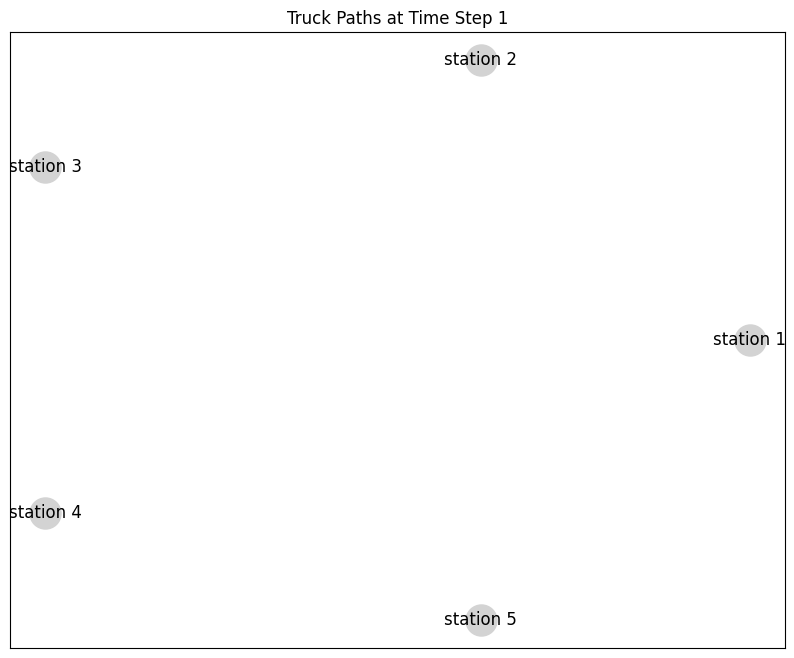

In [13]:
from IPython.display import HTML  # Import HTML from IPython.display
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.animation as animation

# Function to update the animation at each frame
def update(frame):
    plt.clf()  # Clear previous plot
    G = nx.DiGraph()

    num_stations = len(stations)
    angle_step = 2 * np.pi / num_stations
    radius = 0.3  # Radius for station placement

    pos = {stations[i]: (np.cos(i * angle_step) * radius, np.sin(i * angle_step) * radius) for i in range(num_stations)}

    # Add nodes
    for station in stations:
        G.add_node(station)

    colors = ['blue', 'red']
    
    # Plot edges for each truck's path up to the current frame
    # for k, path in truck_paths.items():
    #     current_path = [p for p in path if p[0] <= frame]
    #     if len(current_path) > 1:
    #         edges = [(current_path[i][1], current_path[i + 1][1]) for i in range(len(current_path) - 1)]
    #         nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=15,
    #                                edge_color=colors[k-1], style='dashed', label=f'Truck {k}')

    for k, path in truck_paths.items():
        current_path = [p for p in path if p[0] == frame]
        if len(current_path) > 1:
            edges = [(current_path[i][1], current_path[i + 1][1]) for i in range(len(current_path) - 1)]
            nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=15,
                                       edge_color=colors[k-1], style='dashed', label=f'Truck {k}')
    
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    plt.title(f"Truck Paths at Time Step {frame + 1}")

# Create the animation
fig = plt.figure(figsize=(10, 8))
ani = animation.FuncAnimation(fig, update, frames=T, interval=500, repeat=False)

# Display the animation in the notebook using HTML display
HTML(ani.to_jshtml())

# ani.save('truck_paths_animation.html', writer='html')

# Only Current Time Steps

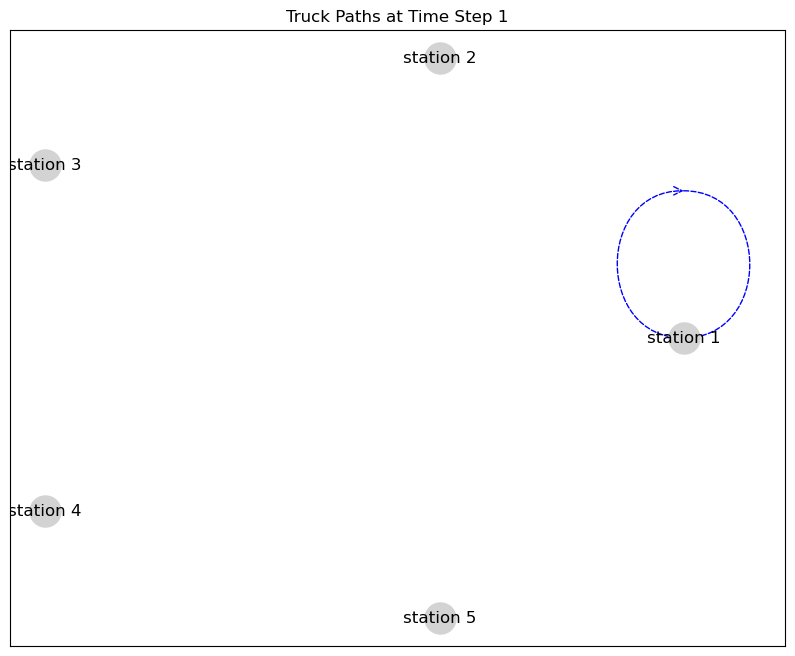

In [74]:
from IPython.display import HTML  # Import HTML from IPython.display
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.animation as animation

num_stations = len(stations)
angle_step = 2 * np.pi / num_stations
radius = 0.3  # Radius for station placement
pos = {stations[i]: (np.cos(i * angle_step) * radius, np.sin(i * angle_step) * radius) for i in range(num_stations)}

# Function to update the animation at each frame
def update(frame):
    plt.clf()  # Clear previous plot
    G = nx.DiGraph()

    # Add nodes
    for station in stations:
        G.add_node(station)

    colors = ['blue', 'red']
    
    # Plot edges for each truck's path at the current frame
    for k, path in truck_paths.items():
        edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1) if path[i][0] == frame]
        if edges:
            nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=15,
                                   edge_color=colors[k-1], style='dashed', label=f'Truck {k}')

    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    plt.title(f"Truck Paths at Time Step {frame}")

# Create the animation
fig = plt.figure(figsize=(10, 8))
ani = animation.FuncAnimation(fig, update, frames=range(1, T + 1), interval=500, repeat=False)

# Display the animation in the notebook using HTML display
HTML(ani.to_jshtml())


# Without Graphing Stationary Trips

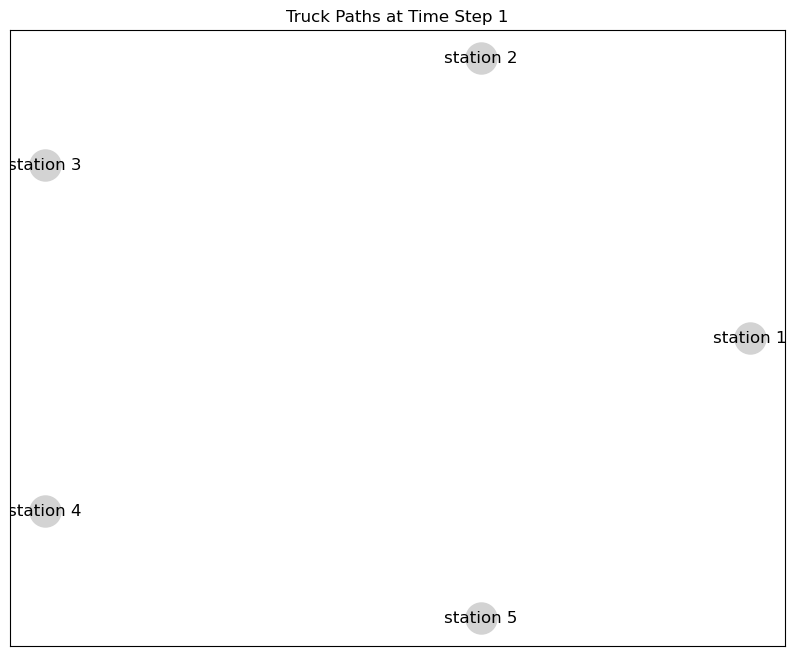

In [77]:
from IPython.display import HTML  # Import HTML from IPython.display
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.animation as animation


# Calculate positions of the stations once
num_stations = len(stations)
angle_step = 2 * np.pi / num_stations
radius = 0.3  # Radius for station placement
pos = {stations[i]: (np.cos(i * angle_step) * radius, np.sin(i * angle_step) * radius) for i in range(num_stations)}

# Function to update the animation at each frame
def update(frame):
    plt.clf()  # Clear previous plot
    G = nx.DiGraph()

    # Add nodes
    for station in stations:
        G.add_node(station)

    colors = ['blue', 'red', 'green']
    
    # Plot edges for each truck's path at the current frame
    for k, path in truck_paths.items():
        edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1) if path[i][0] == frame and path[i][1] != path[i + 1][1]]
        if edges:
            nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=15,
                                   edge_color=colors[k-1], style='dashed', label=f'Truck {k}')

    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    plt.title(f"Truck Paths at Time Step {frame}")

# Create the animation
fig = plt.figure(figsize=(10, 8))
ani = animation.FuncAnimation(fig, update, frames=range(1, T + 1), interval=500, repeat=False)

# Display the animation in the notebook using HTML display
HTML(ani.to_jshtml())

# ani.save('truck_paths_animation.html', writer = 'html')


# Testing

In [3]:
import gurobipy as gp
from gurobipy import GRB

stations = ['station 1', 'station 2', 'station 3', 'station 4', 'station 5']
start_levels = {'station 1': 30, 'station 2': 15, 'station 3': 15, 'station 4': 0, 'station 5': 15}
optimal_levels = {'station 1': 15, 'station 2': 15, 'station 3': 15, 'station 4': 15, 'station 5': 15}
over_stations, under_stations = [], []

# Fill over and under stations
for station in stations:
    if start_levels[station] > optimal_levels[station]:
        over_stations.append(station)
    elif start_levels[station] < optimal_levels[station]:
        under_stations.append(station)
        
T = 10 # Number of time steps
K = 1 # Number of trucks
L = 3 # Number of bikes that can be moved in one time step

travel_time = {
    ('station 1', 'station 2'): 1,
    ('station 1', 'station 3'): 1,
    ('station 1', 'station 4'): 3,
    ('station 1', 'station 5'): 1,
    ('station 2', 'station 3'): 1,
    ('station 2', 'station 4'): 3,
    ('station 2', 'station 5'): 1,
    ('station 3', 'station 4'): 3,
    ('station 3', 'station 5'): 1,
    ('station 4', 'station 5'): 3,
    # Symmetric entries
    ('station 2', 'station 1'): 1,
    ('station 3', 'station 1'): 1,
    ('station 4', 'station 1'): 3,
    ('station 5', 'station 1'): 1,
    ('station 3', 'station 2'): 1,
    ('station 4', 'station 2'): 3,
    ('station 5', 'station 2'): 1,
    ('station 4', 'station 3'): 3,
    ('station 5', 'station 3'): 1,
    ('station 5', 'station 4'): 3,
    # Diagonal entries
    ('station 1', 'station 1'): 0,
    ('station 2', 'station 2'): 0,
    ('station 3', 'station 3'): 0,
    ('station 4', 'station 4'): 0,
    ('station 5', 'station 5'): 0
}

model = gp.Model("bike_rebalancing")

# Decision variables
x, y, b, z = {}, {}, {}, {}
for t in range(1, T+1):
    for k in range(1, K+1):
        for s in stations:
            x[s, t, k] = model.addVar(name="x_%s,%s,%s" % (s, t, k), vtype=GRB.BINARY)
            y[s, t, k] = model.addVar(name="y_%s,%s,%s" % (s, t, k), vtype=GRB.INTEGER, lb=0)
        b[t, k] = model.addVar(name="b_%s,%s" % (t, k), vtype=GRB.INTEGER, lb=0)
        for s1 in stations:
            for s2 in stations:
                z[s1, s2, t, k] = model.addVar(name="z_%s,%s,%s,%s" % (s1, s2, t, k), vtype=GRB.BINARY)

# Auxiliary variables for absolute deviation
deviation = {}
for s in stations:
    deviation[s] = model.addVar(name="deviation_%s" % s, vtype=GRB.INTEGER)

model.update()

# Objective function: minimize total absolute deviation from optimal levels
objective = gp.quicksum(deviation[s] for s in stations)
model.setObjective(objective, sense=GRB.MINIMIZE)

# Constraints

# Each truck must be at exactly 1 station always
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(x[s, t, k] for s in stations) == 1)

# Initialize bike levels at time 1
for s in stations:
    model.addConstr(sum(y[s, 1, k] for k in range(1, K+1)) == start_levels[s])

# Rebalancing can only bring a station closer to optimal level
for t in range(1, T+1):
    for s in over_stations:
        model.addConstr(optimal_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= start_levels[s])
    for s in under_stations:
        model.addConstr(start_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= optimal_levels[s])

# Total number of bikes is constant
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(y[s, t, k] for s in stations) + b[t, k] == sum(y[s, 1, k] for s in stations) + b[1, k])

# Can move only when truck is at station; number of bikes moved is bounded
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(y[s, t, k] - y[s, t-1, k] <= L * x[s, t, k])
            model.addConstr(y[s, t-1, k] - y[s, t, k] <= L * x[s, t, k])

# Constraint 8 in paper
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in over_stations:
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) <= L + (y[s,t,k] - y[s,t-1,k]))
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) >= -L - (y[s,t,k] - y[s,t-1,k]))
        for s in under_stations:
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) <= L - (y[s,t,k] - y[s,t-1,k]))
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) >= -L + (y[s,t,k] - y[s,t-1,k]))

# each truck can only house L bikes
for k in range(1, K+1):
    for t in range(1, T+1):
        model.addConstr(b[t, k] <= L)

# Absolute deviation constraints
for s in stations:
    model.addConstr(deviation[s] >= optimal_levels[s] - sum(y[s, T, k] for k in range(1, K+1)))
    model.addConstr(deviation[s] >= sum(y[s, T, k] for k in range(1, K+1)) - optimal_levels[s])

# Travel constraints
for t in range(1, T):
    for k in range(1, K+1):
        for s1 in stations:
            for s2 in stations:
                if t + travel_time[(s1, s2)] <= T:
                    model.addConstr(z[s1, s2, t, k] <= x[s1, t, k])
                    model.addConstr(z[s1, s2, t, k] <= x[s2, t + travel_time[(s1, s2)], k])
                    model.addConstr(z[s1, s2, t, k] >= x[s1, t, k] + x[s2, t + travel_time[(s1, s2)], k] - 1)
                    for t1 in range(t+1, t + travel_time[(s1, s2)]):
                        model.addConstr(x[s1, t, k] + x[s2, t1, k] <= 1 + z[s1, s2, t, k]) 

# at beginning and end, there must be no bikes in trucks
model.addConstr(gp.quicksum(b[T, k] for k in range(1, K+1)) == 0)
model.addConstr(gp.quicksum(b[1, k] for k in range(1, K+1)) == 0)

model.optimize()


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 17.7.0 17G14042)

CPU model: Intel(R) Core(TM) i5-4250U CPU @ 1.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 952 rows, 365 columns and 2403 nonzeros
Model fingerprint: 0xfce75687
Variable types: 0 continuous, 365 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Presolve removed 547 rows and 205 columns
Presolve time: 0.03s
Presolved: 405 rows, 160 columns, 1149 nonzeros
Variable types: 0 continuous, 160 integer (106 binary)
Found heuristic solution: objective 30.0000000

Root relaxation: objective 4.500000e+00, 121 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.5000

In [15]:
import gurobipy as gp
from gurobipy import GRB

stations = ['station 1', 'station 2', 'station 3', 'station 4', 'station 5']
start_levels = {'station 1': 30, 'station 2': 15, 'station 3': 15, 'station 4': 0, 'station 5': 15}
optimal_levels = {'station 1': 15, 'station 2': 15, 'station 3': 15, 'station 4': 15, 'station 5': 15}
over_stations, under_stations = [], []

# Fill over and under stations
for station in stations:
    if start_levels[station] > optimal_levels[station]:
        over_stations.append(station)
    elif start_levels[station] < optimal_levels[station]:
        under_stations.append(station)
        
T = 20 # Number of time steps
K = 1 # Number of trucks
L = 3 # Number of bikes that can be moved in one time step

travel_time = {
    ('station 1', 'station 2'): 1,
    ('station 1', 'station 3'): 1,
    ('station 1', 'station 4'): 3,
    ('station 1', 'station 5'): 1,
    ('station 2', 'station 3'): 1,
    ('station 2', 'station 4'): 3,
    ('station 2', 'station 5'): 1,
    ('station 3', 'station 4'): 3,
    ('station 3', 'station 5'): 1,
    ('station 4', 'station 5'): 3,
    # Symmetric entries
    ('station 2', 'station 1'): 1,
    ('station 3', 'station 1'): 1,
    ('station 4', 'station 1'): 3,
    ('station 5', 'station 1'): 1,
    ('station 3', 'station 2'): 1,
    ('station 4', 'station 2'): 3,
    ('station 5', 'station 2'): 1,
    ('station 4', 'station 3'): 3,
    ('station 5', 'station 3'): 1,
    ('station 5', 'station 4'): 3,
    # Diagonal entries
    ('station 1', 'station 1'): 0,
    ('station 2', 'station 2'): 0,
    ('station 3', 'station 3'): 0,
    ('station 4', 'station 4'): 0,
    ('station 5', 'station 5'): 0
}

model = gp.Model("bike_rebalancing")

# Decision variables
x, y, b, z = {}, {}, {}, {}
for t in range(1, T+1):
    for k in range(1, K+1):
        for s in stations:
            x[s, t, k] = model.addVar(name="x_%s,%s,%s" % (s, t, k), vtype=GRB.BINARY)
            y[s, t, k] = model.addVar(name="y_%s,%s,%s" % (s, t, k), vtype=GRB.INTEGER, lb=0)
        b[t, k] = model.addVar(name="b_%s,%s" % (t, k), vtype=GRB.INTEGER, lb=0)
        for s1 in stations:
            for s2 in stations:
                z[s1, s2, t, k] = model.addVar(name="z_%s,%s,%s,%s" % (s1, s2, t, k), vtype=GRB.BINARY)

# Transit state variables
transit = {}
for t in range(1, T+1):
    for k in range(1, K+1):
        for s1 in stations:
            for s2 in stations:
                if s1 != s2:
                    transit[s1, s2, t, k] = model.addVar(name="transit_%s,%s,%s,%s" % (s1, s2, t, k), vtype=GRB.BINARY)

# Auxiliary variables for absolute deviation
deviation = {}
for s in stations:
    deviation[s] = model.addVar(name="deviation_%s" % s, vtype=GRB.INTEGER)

model.update()

# Objective function: minimize total absolute deviation from optimal levels
objective = gp.quicksum(deviation[s] for s in stations)
model.setObjective(objective, sense=GRB.MINIMIZE)

# Constraints

# Each truck must be at exactly 1 station or in transit always
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(x[s, t, k] for s in stations) + gp.quicksum(transit[s1, s2, t, k] for s1 in stations for s2 in stations if s1 != s2) == 1)

# Initialize bike levels at time 1
for s in stations:
    model.addConstr(sum(y[s, 1, k] for k in range(1, K+1)) == start_levels[s])

# Rebalancing can only bring a station closer to optimal level
for t in range(1, T+1):
    for s in over_stations:
        model.addConstr(optimal_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= start_levels[s])
    for s in under_stations:
        model.addConstr(start_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= optimal_levels[s])

# Total number of bikes is constant
for t in range(1, T+1):
    model.addConstr(sum(sum(y[s, t, k] for s in stations) + b[t, k] for k in range(1, K+1)) 
                    == sum(sum(y[s, 1, k] for s in stations) + b[1, k] for k in range(1,K+1)))

# Can move only when truck is at station; number of bikes moved is bounded
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(y[s, t, k] - y[s, t-1, k] <= L * x[s, t, k])
            model.addConstr(y[s, t-1, k] - y[s, t, k] <= L * x[s, t, k])

# Constraint 8 in paper
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in over_stations:
            model.addConstr(L * (x[s, t, k] - x[s, t-1, k]) <= L + (y[s, t, k] - y[s, t-1, k]))
            model.addConstr(L * (x[s, t, k] - x[s, t-1, k]) >= -L - (y[s, t, k] - y[s, t-1, k]))
        for s in under_stations:
            model.addConstr(L * (x[s, t, k] - x[s, t-1, k]) <= L - (y[s, t, k] - y[s, t-1, k]))
            model.addConstr(L * (x[s, t, k] - x[s, t-1, k]) >= -L + (y[s, t, k] - y[s, t-1, k]))

# Each truck can only house L bikes
for k in range(1, K+1):
    for t in range(1, T+1):
        model.addConstr(b[t, k] <= L)

# Absolute deviation constraints
for s in stations:
    model.addConstr(deviation[s] >= optimal_levels[s] - sum(y[s, T, k] for k in range(1, K+1)))
    model.addConstr(deviation[s] >= sum(y[s, T, k] for k in range(1, K+1)) - optimal_levels[s])

# Travel constraints
for t in range(1, T):
    for k in range(1, K+1):
        for s1 in stations:
            for s2 in stations:
                if s1 != s2 and t + travel_time[(s1, s2)] <= T:
                    # model.addConstr(z[s1, s2, t, k] <= x[s1, t, k])
                    # model.addConstr(z[s1, s2, t, k] <= x[s2, t + travel_time[(s1, s2)], k])
                    # model.addConstr(z[s1, s2, t, k] >= x[s1, t, k] + x[s2, t + travel_time[(s1, s2)], k] - 1)

                    # Ensure the truck is in transit state for the entire travel duration
                    for t_transit in range(t + 1, t + travel_time[(s1, s2)]):
                        model.addConstr(transit[s1, s2, t_transit, k] == z[s1, s2, t, k])

# Ensure truck cannot be at a station while in transit
for t in range(1, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(x[s, t, k] + gp.quicksum(transit[s1, s2, t, k] for s1 in stations for s2 in stations if s1 != s2) <= 1)

# At beginning and end, there must be no bikes in trucks
model.addConstr(gp.quicksum(b[T, k] for k in range(1, K+1)) == 0)
model.addConstr(gp.quicksum(b[1, k] for k in range(1, K+1)) == 0)

model.optimize()


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 17.7.0 17G14042)

CPU model: Intel(R) Core(TM) i5-4250U CPU @ 1.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 795 rows, 1125 columns and 4373 nonzeros
Model fingerprint: 0x3481da32
Variable types: 0 continuous, 1125 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Presolve removed 533 rows and 916 columns
Presolve time: 0.02s
Presolved: 262 rows, 209 columns, 920 nonzeros
Variable types: 0 continuous, 209 integer (95 binary)
Found heuristic solution: objective 30.0000000
Found heuristic solution: objective 28.0000000
Found heuristic solution: objective 24.0000000

Root relaxation: objective 0.000000e+00, 212 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl

# Try this

In [69]:
import gurobipy as gp
from gurobipy import GRB

stations = ['station 1', 'station 2', 'station 3', 'station 4', 'station 5']
start_levels = {'station 1': 30, 'station 2': 15, 'station 3': 15, 'station 4': 0, 'station 5': 15}
optimal_levels = {'station 1': 15, 'station 2': 15, 'station 3': 15, 'station 4': 15, 'station 5': 15}
over_stations, under_stations = [], []

# Fill over and under stations
for station in stations:
    if start_levels[station] > optimal_levels[station]:
        over_stations.append(station)
    elif start_levels[station] < optimal_levels[station]:
        under_stations.append(station)
        
T = 20 # Number of time steps
K = 1 # Number of trucks
L = 3 # Number of bikes that can be moved in one time step

travel_time = {
    ('station 1', 'station 2'): 1,
    ('station 1', 'station 3'): 1,
    ('station 1', 'station 4'): 3,
    ('station 1', 'station 5'): 1,
    ('station 2', 'station 3'): 1,
    ('station 2', 'station 4'): 3,
    ('station 2', 'station 5'): 1,
    ('station 3', 'station 4'): 3,
    ('station 3', 'station 5'): 1,
    ('station 4', 'station 5'): 3,
    # Symmetric entries
    ('station 2', 'station 1'): 1,
    ('station 3', 'station 1'): 1,
    ('station 4', 'station 1'): 3,
    ('station 5', 'station 1'): 1,
    ('station 3', 'station 2'): 1,
    ('station 4', 'station 2'): 3,
    ('station 5', 'station 2'): 1,
    ('station 4', 'station 3'): 3,
    ('station 5', 'station 3'): 1,
    ('station 5', 'station 4'): 3,
    # Diagonal entries
    ('station 1', 'station 1'): 0,
    ('station 2', 'station 2'): 0,
    ('station 3', 'station 3'): 0,
    ('station 4', 'station 4'): 0,
    ('station 5', 'station 5'): 0
}

model = gp.Model("bike_rebalancing")

# Decision variables
x, y, b, z = {}, {}, {}, {}
for t in range(1, T+1):
    for k in range(1, K+1):
        for s in stations:
            x[s, t, k] = model.addVar(name="x_%s,%s,%s" % (s, t, k), vtype=GRB.BINARY)
            y[s, t, k] = model.addVar(name="y_%s,%s,%s" % (s, t, k), vtype=GRB.INTEGER, lb=0)
        b[t, k] = model.addVar(name="b_%s,%s" % (t, k), vtype=GRB.INTEGER, lb=0)
        for s1 in stations:
            for s2 in stations:
                z[s1, s2, t, k] = model.addVar(name="z_%s,%s,%s,%s" % (s1, s2, t, k), vtype=GRB.BINARY)

# Transit state variables... are you traveling from s1 to s2
transit = {}
for t in range(1, T+1):
    for k in range(1, K+1):
        for s1 in stations:
            for s2 in stations:
                transit[s1, s2, t, k] = model.addVar(name="transit_%s,%s" % (t, k), vtype=GRB.BINARY)

# Auxiliary variables for absolute deviation
deviation = {}
for s in stations:
    deviation[s] = model.addVar(name="deviation_%s" % s, vtype=GRB.INTEGER)

model.update()

# Objective function: minimize total absolute deviation from optimal levels
objective = gp.quicksum(deviation[s] for s in stations)
model.setObjective(objective, sense=GRB.MINIMIZE)

# Constraints

# Each truck must be at exactly 1 station or in transit always
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(x[s, t, k] for s in stations) + gp.quicksum(transit[s1, s2, t, k] for s1 in stations for s2 in stations) == 1)

# Initialize bike levels at time 1
for s in stations:
    model.addConstr(sum(y[s, 1, k] for k in range(1, K+1)) == start_levels[s])

# Rebalancing can only bring a station closer to optimal level
for t in range(1, T+1):
    for s in over_stations:
        model.addConstr(optimal_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= start_levels[s])
    for s in under_stations:
        model.addConstr(start_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= optimal_levels[s])

# Total number of bikes is constant
for t in range(1, T+1):
    model.addConstr(sum(sum(y[s, t, k] for s in stations) + b[t, k] for k in range(1, K+1)) 
                    == sum(sum(y[s, 1, k] for s in stations) + b[1, k] for k in range(1,K+1)))

# Can move only when truck is at station; number of bikes moved is bounded
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(y[s, t, k] - y[s, t-1, k] <= L * x[s, t, k])
            model.addConstr(y[s, t-1, k] - y[s, t, k] <= L * x[s, t, k])

# Constraint 8 in paper
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in over_stations:
            model.addConstr(L * (x[s, t, k] - x[s, t-1, k]) <= L + (y[s, t, k] - y[s, t-1, k]))
            model.addConstr(L * (x[s, t, k] - x[s, t-1, k]) >= -L - (y[s, t, k] - y[s, t-1, k]))
        for s in under_stations:
            model.addConstr(L * (x[s, t, k] - x[s, t-1, k]) <= L - (y[s, t, k] - y[s, t-1, k]))
            model.addConstr(L * (x[s, t, k] - x[s, t-1, k]) >= -L + (y[s, t, k] - y[s, t-1, k]))

# Each truck can only house L bikes
for k in range(1, K+1):
    for t in range(1, T+1):
        model.addConstr(b[t, k] <= L)

# Absolute deviation constraints
for s in stations:
    model.addConstr(deviation[s] >= optimal_levels[s] - sum(y[s, T, k] for k in range(1, K+1)))
    model.addConstr(deviation[s] >= sum(y[s, T, k] for k in range(1, K+1)) - optimal_levels[s])

# I think this one is just wrong, there is a contraint above that covers this
# # Ensure truck cannot be at a station while in transit
# for t in range(1, T+1):
#     for k in range(1, K+1):
#         for s in stations:
#             model.addConstr(x[s, t, k] + gp.quicksum(transit[s1, s2, t, k] for s1 in stations for s2 in stations) == 1)

# If truck is at a station, there is a trip starting at that time
for t in range(1, T):
    for k in range(1, K+1):
        for s1 in stations:
            model.addConstr(x[s1,t,k] == gp.quicksum(z[s1,s2,t,k] for s2 in stations))

# If truck makes a trip from s1 to s2, it must be in transit for the time in between
for t in range(1, T):
    for k in range(1, K+1):
        for s1 in stations:
            for s2 in stations:
                if t + travel_time[(s1, s2)] <= T:
                    for t1 in range(t+1, t + travel_time[(s1, s2)]):
                        model.addConstr(z[s1,s2,t,k] == transit[s1, s2, t1, k])

# if truck makes trip from s1 to s2, it must be at s1 @ t, and s2 @ t + travel_time
for t in range(1, T):
    for k in range(1, K+1):
        for s1 in stations:
            for s2 in stations:
                if t + travel_time[(s1, s2)] <= T:
                    model.addConstr(x[s1,t,k] + x[s2,t+travel_time[(s1,s2)],k] >= 1.5 * z[s1,s2,t,k])

# need (??) to add a constraint saying that there is only one trip per time step per truck

# if truck leaves a station, then there must be a trip to a different station at that time step
# for t in range(1, T):
#     for k in range(1, K+1):
#         for s1 in stations:
#             model.addConstr(sum(z[s1,s2,t,k] for s2 in stations if s2 != s1) <= 1 - (x[s1,t,k] * x[s1,t+1,k]))
#             model.addConstr(sum(z[s1,s2,t,k] for s2 in stations if s2 != s1) >= x[s1,t,k] - x[s1,t+1,k])
#             model.addConstr(sum(z[s1,s2,t,k] for s2 in stations if s2 != s1) <= 1 - x[s1,t,k])
#             model.addConstr(sum(z[s1,s2,t,k] for s2 in stations if s2 != s1) <= 1 - x[s1,t+1,k])

# if a station is n time steps away, for the next n time steps you can't be there
for t in range(1, T):
    for k in range(1, K+1):
        for s1 in stations:
            for s2 in stations:
                if t + travel_time[(s1, s2)] <= T:
                    for t1 in range(t+1, t + travel_time[(s1, s2)]):
                        model.addConstr(x[s1,t,k] + x[s2,t1,k] <= 1)

# At beginning and end, there must be no bikes in trucks
model.addConstr(gp.quicksum(b[T, k] for k in range(1, K+1)) == 0)
model.addConstr(gp.quicksum(b[1, k] for k in range(1, K+1)) == 0)

model.optimize()

# what if i say that if k is at s1 

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 17.7.0 17G14042)

CPU model: Intel(R) Core(TM) i5-4250U CPU @ 1.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1521 rows, 1225 columns and 4769 nonzeros
Model fingerprint: 0xe691d3c9
Variable types: 0 continuous, 1225 integer (1100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Presolve removed 1199 rows and 1018 columns
Presolve time: 0.03s
Presolved: 322 rows, 207 columns, 1201 nonzeros
Variable types: 0 continuous, 207 integer (94 binary)
Found heuristic solution: objective 30.0000000

Root relaxation: objective 0.000000e+00, 245 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0